# Image Reconstruction by Deconvolution, Denoising and Fusion

Jupyter compare_view v0.2.4


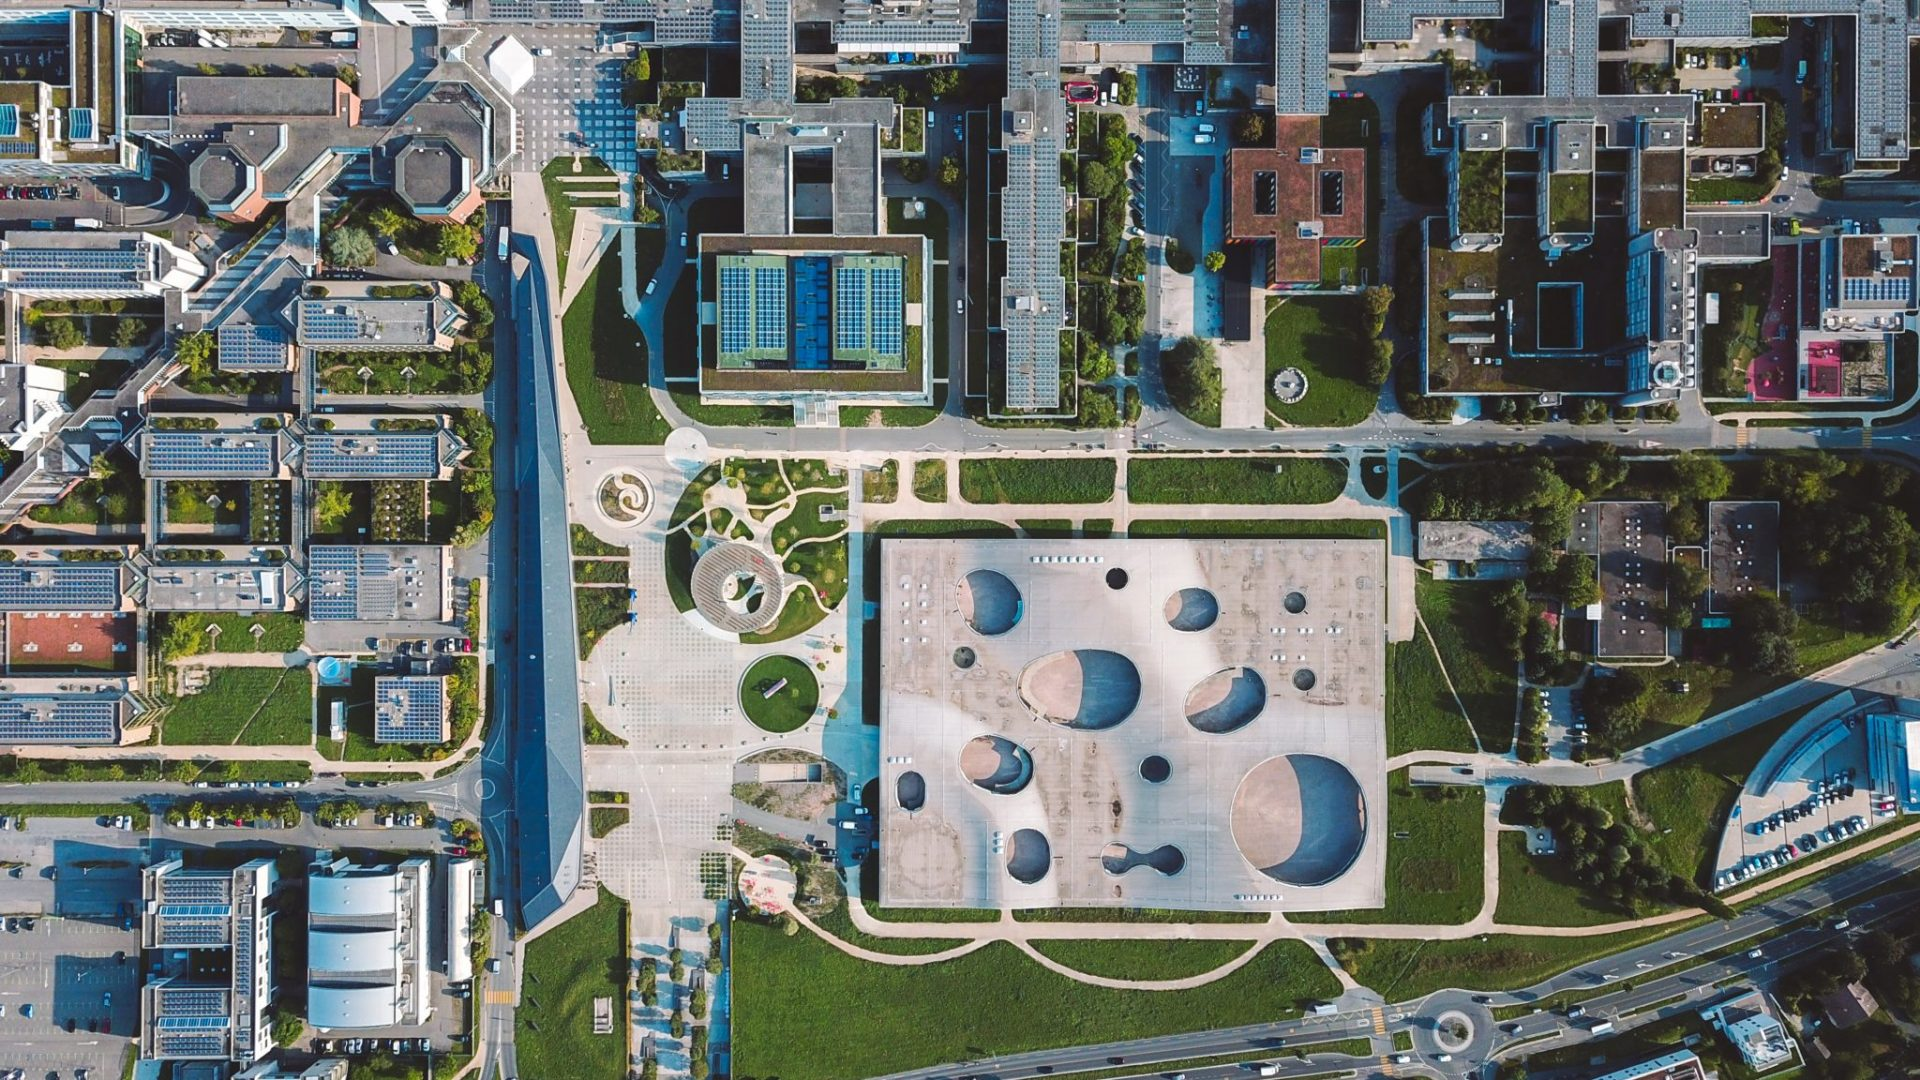

In [1]:
from PIL import Image
from jupyter_compare_view import compare as compare_view

dtype = "float32"
import pyxu.runtime as pxrt
pxrt._setPrecision(pxrt.Width.SINGLE)

GPU = True

if GPU:
    import cupy as xp
    compare = lambda x, y, **kwargs: compare_view(x.get(), y.get(), **kwargs)
else: 
    import numpy as xp
    compare = compare_view

# Load the image
image_path = '../data/EPFL_aereal.jpeg'
ground_truth_image = Image.open(image_path)
ground_truth_image

In [2]:
# Convert the image to a numpy array
image = xp.array(ground_truth_image)[-512:, -1024:].astype(dtype) / 255.

dim_shape = image.shape
print(dim_shape)

(512, 1024, 3)


## Lens 


In [3]:
import scipy.signal as ss

def get_window(name, size):
    return xp.array(ss.get_window(name, size), dtype=dtype)

In [4]:
import pyxu.runtime as pxrt
import pyxu.operator as pxo

wsize = 20
filt = get_window('hamming', wsize)
psf = filt / filt.sum()

lens_op = pxo.Convolve(
    dim_shape=dim_shape,
    kernel=[psf, psf, xp.array(1., dtype=dtype)], 
    center=[wsize//2, wsize//2, 0], 
)

print(lens_op.lipschitz)

0.99999976


In [5]:
# Convolution with PSF
data_lens = lens_op(image)


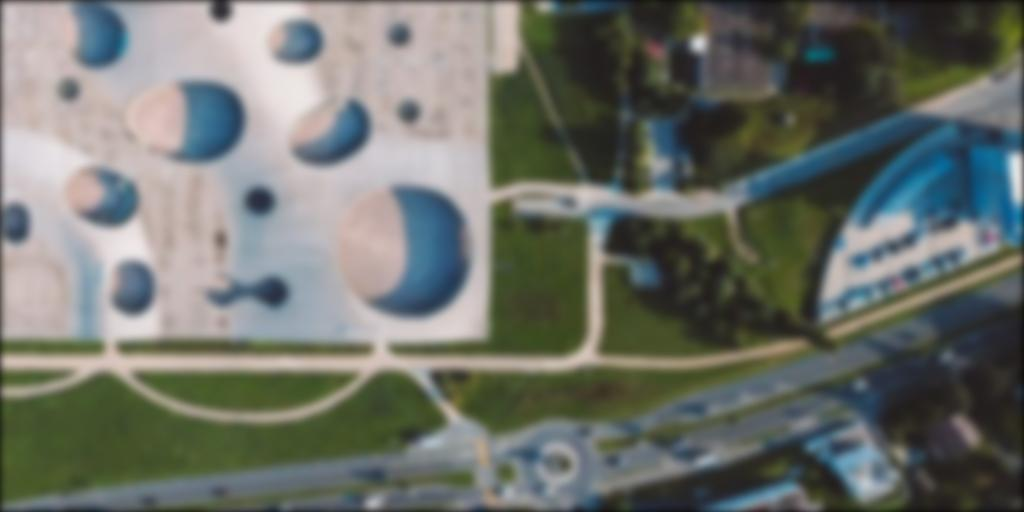
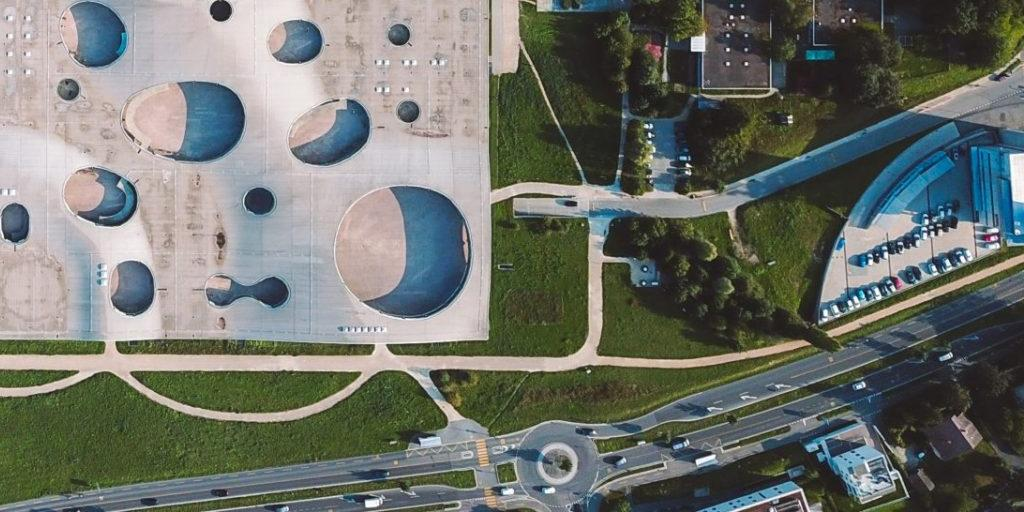

In [6]:
compare(data_lens, image, circle_fraction=0.1)

## Pinhole photography

In [7]:
 # Tapering
tukey_window = xp.outer(get_window('tukey', image.shape[1]), get_window('tukey', image.shape[0]))
taper_op = pxo.DiagonalOp(xp.tile(tukey_window, (3, 1, 1)).T)
taper_op.lipschitz = taper_op.estimate_lipschitz()

# Partial Masking 
mask = xp.ones(image.shape, dtype=dtype)
mask[100:250, 200:300] = 0.1
mask[250:300, 700:750] = 0.3
mask_op = pxo.DiagonalOp(vec=mask, dim_shape=dim_shape)
mask_op.lipschitz = mask_op.estimate_lipschitz()

# Compose Tapering and Masking operators
pinhole_op = mask_op * taper_op
pinhole_op.lipschitz

1.0

In [8]:
data_pinhole = pinhole_op(image) # Low exposure 
data_pinhole = xp.clip(xp.random.normal(loc=data_pinhole, scale=xp.sqrt(data_pinhole)/4).astype(dtype), a_min=0, a_max=1) # shot noise


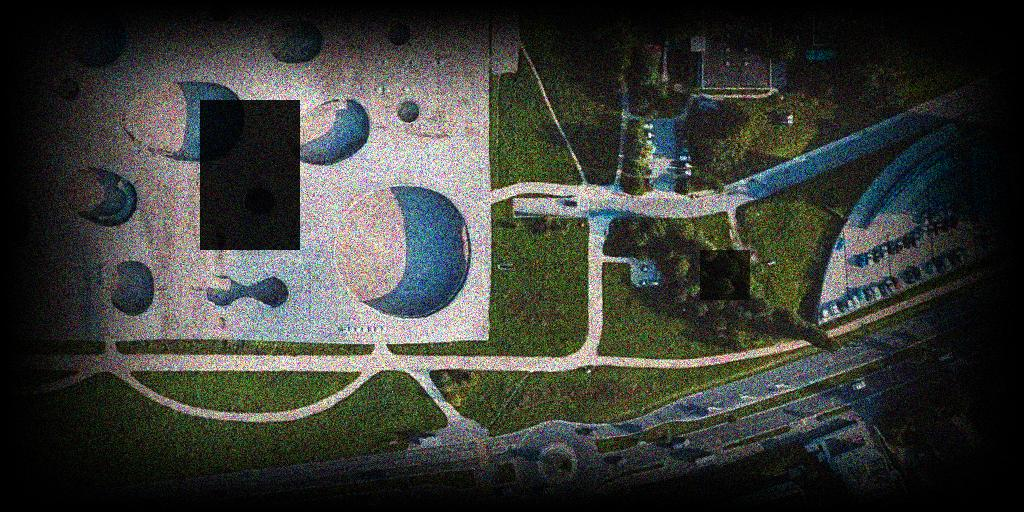
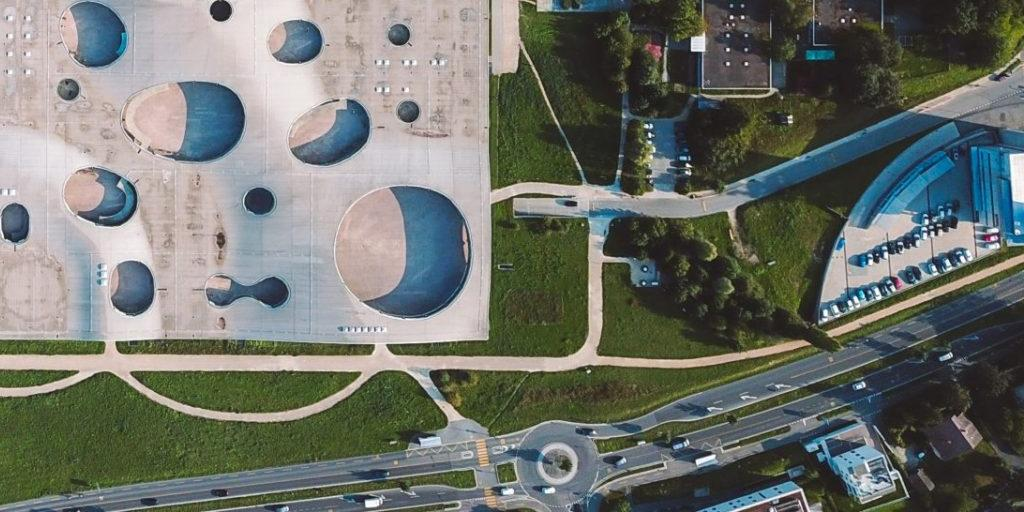

In [9]:
compare(data_pinhole, image, circle_fraction=0.1)


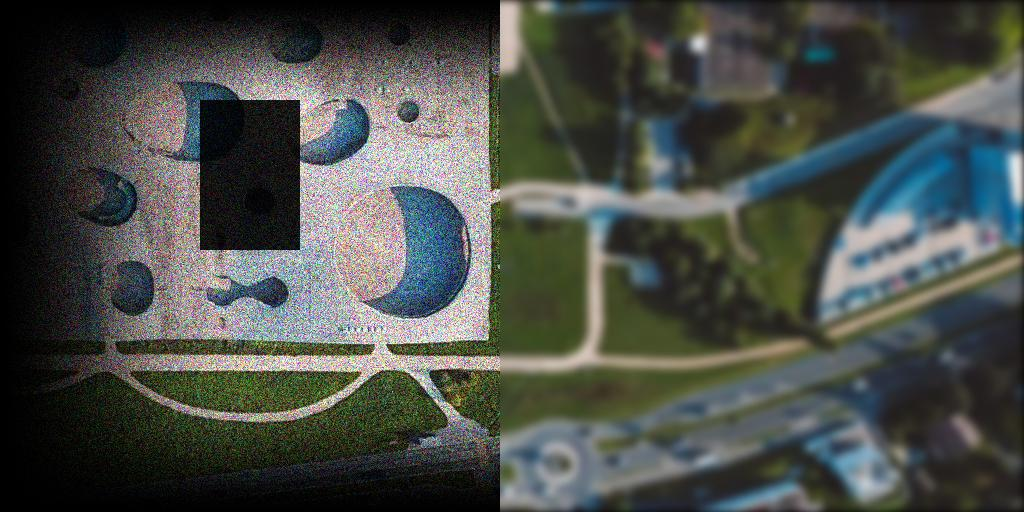
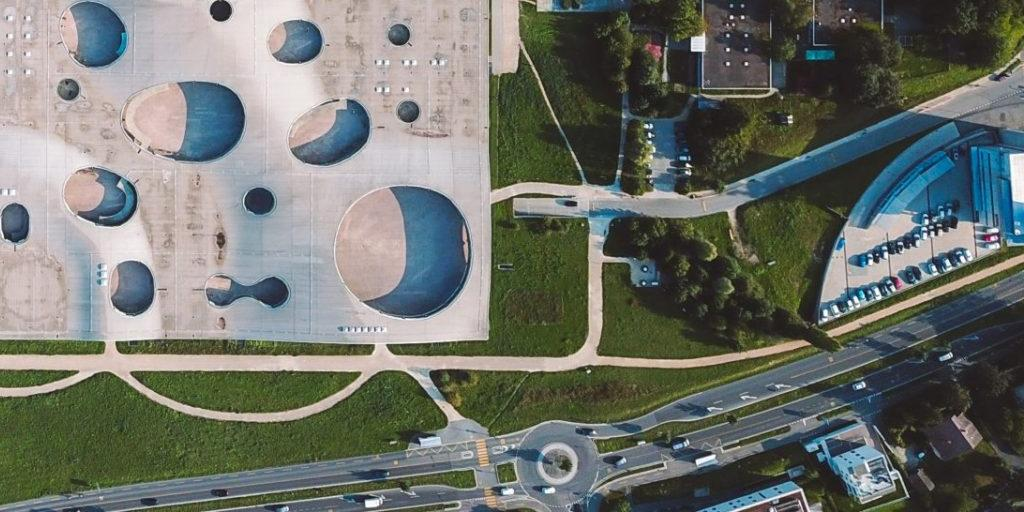

In [10]:
data_merge = xp.concatenate([data_pinhole[:, :500], data_lens[:, 500:]], axis=1)
compare(data_merge, image, circle_fraction=0.1)

## Pseudo-inverse Solution

In [11]:
import pyxu.operator.blocks as pxb
sensing_op = pxb.stack([0.7*lens_op,0.3*pinhole_op])

In [12]:
sensing_op

LinOp(dim=(512, 1024, 3), codim=(2, 512, 1024, 3))

In [13]:
data = xp.stack([0.7*data_lens, 0.3*data_pinhole])
data.shape

(2, 512, 1024, 3)

In [14]:
adj_recon = sensing_op.adjoint(data)


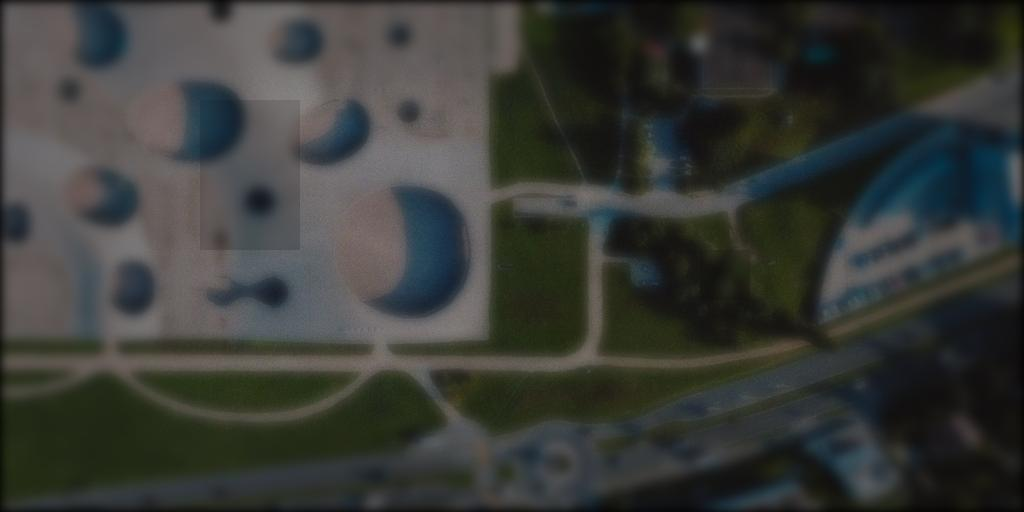
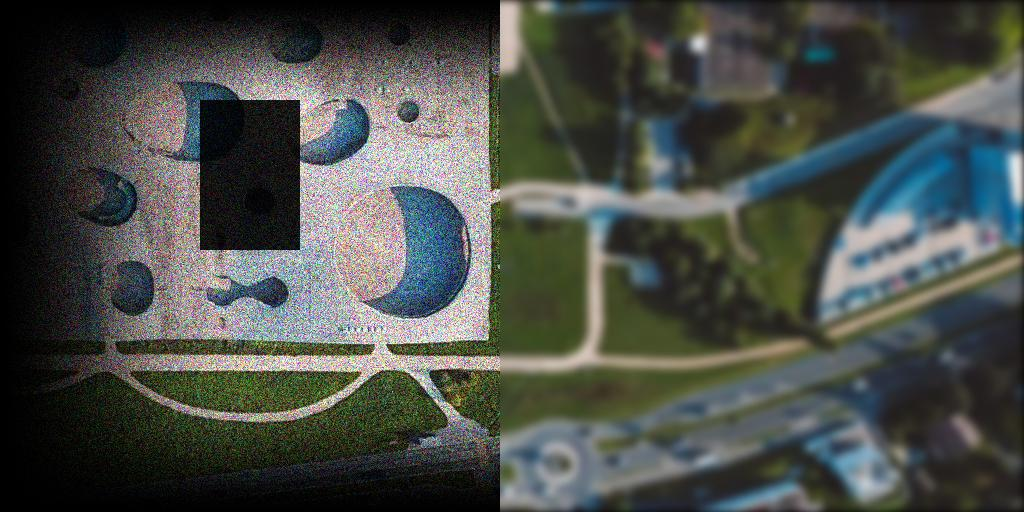

In [15]:
compare(adj_recon, data_merge, circle_fraction=0.1)

In [16]:
import pyxu.opt.stop as pxst

stop_crit = pxst.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) | pxst.MaxIter(500)


pinv_solution = sensing_op.pinv(data, damp=0.01,
                         kwargs_init=dict(verbosity=500),
                         kwargs_fit=dict(stop_crit=stop_crit))
# solvers --> not save by default (solver.__innit__ and solver.step)


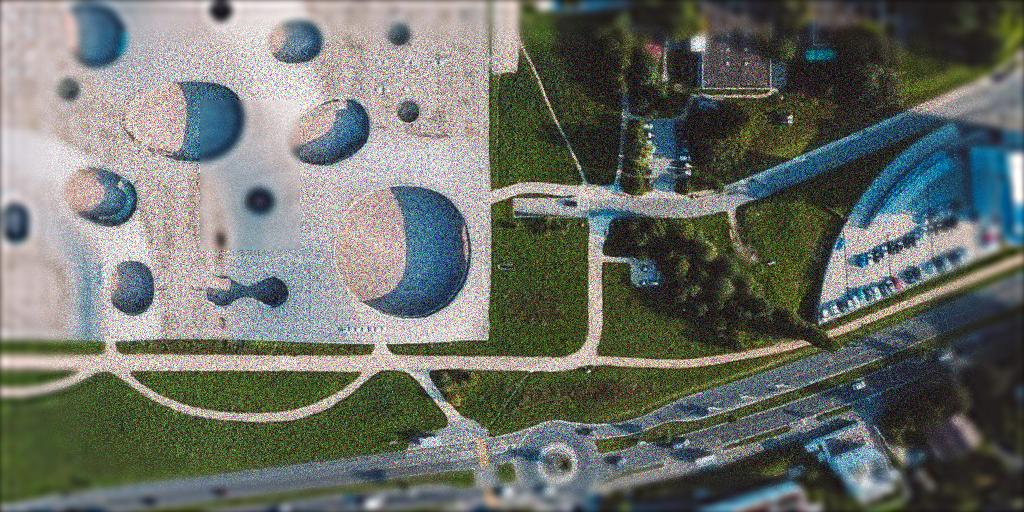
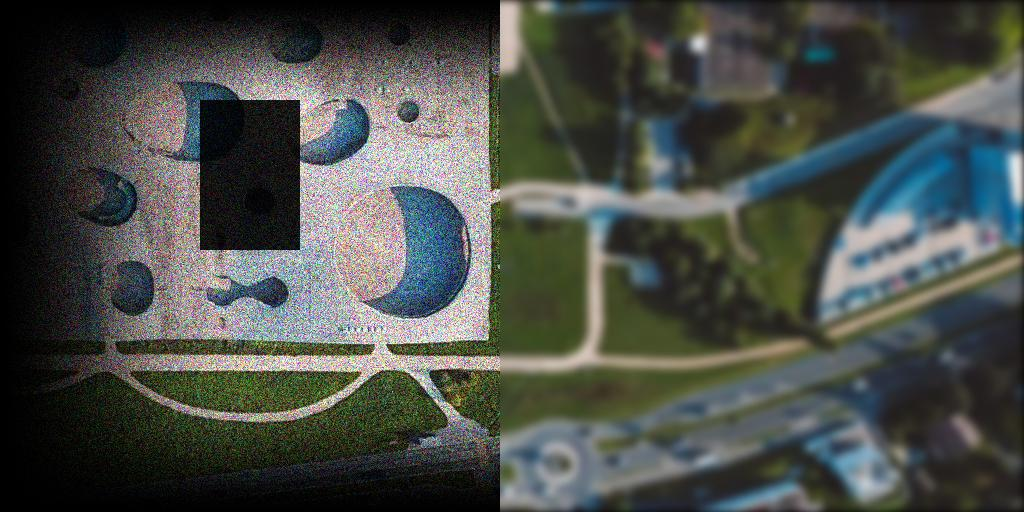

In [17]:
compare(pinv_solution.clip(0, 1), data_merge, circle_fraction=0.1)

## Bayesian Inversion

## Likelihood

In [18]:
theta = 10, 0.006

loss_lens = theta[0] * pxo.SquaredL2Norm(dim_shape=dim_shape).argshift(-data_lens) * lens_op
loss_pinhole = theta[1] * pxo.L1Norm(dim_shape=dim_shape).moreau_envelope(0.01).argshift(-data_pinhole) * pinhole_op
loss = loss_lens + loss_pinhole

### Prior

In [19]:
# Define multi-channel TV prior
grad_kwags = {"dim_shape":dim_shape, "directions":(0, 1), "accuracy":4, "mode":"constant", "gpu":GPU, "dtype":dtype}

grad = pxo.Gradient(**grad_kwags)
lambda_= .005
l21_norm = lambda_ * pxo.L21Norm(dim_shape=grad.codim_shape, l2_axis=(0, 3))
# Positivity constraint
pos_constraint = pxo.PositiveOrthant(dim_shape=dim_shape)

In [20]:
loss.diff_lipschitz

20.599993

In [21]:
import pyxu.opt.solver as pxsol

# Stopping criterion
default_stop_crit = (pxst.RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) & 
                    pxst.RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                    pxst.MaxIter(20)) | pxst.MaxIter(1000)

# Initialize solver (Condat-Vu primal-dual splitting algorithm in this case)
solver = pxsol.CondatVu(f=loss, g=pos_constraint, h=l21_norm, K=grad, verbosity=100)

# Fit  
solver.fit(
    x0=pinv_solution, 
    tuning_strategy=2, 
    stop_crit=default_stop_crit
)
isotv_solution = solver.solution()

INFO -- [2024-03-25 16:40:15.259194] Iteration 0
	iteration: 0
	RelError[x]_min: 0.0
	RelError[x]_max: 0.0
	RelError[z]_min: 0.0
	RelError[z]_max: 0.0
	N_iter: 1.0
INFO -- [2024-03-25 16:40:19.223572] Iteration 100
	iteration: 100
	RelError[x]_min: 9.089678201235074e-07
	RelError[x]_max: 0.027103114873170853
	RelError[z]_min: 1.1487171605040203e-06
	RelError[z]_max: 2.8734092712402344
	N_iter: 101.0
INFO -- [2024-03-25 16:40:23.141345] Iteration 200
	iteration: 200
	RelError[x]_min: 2.5942537718037784e-07
	RelError[x]_max: 0.01111634075641632
	RelError[z]_min: 1.7071446336558438e-06
	RelError[z]_max: 3.0535409450531006
	N_iter: 201.0
INFO -- [2024-03-25 16:40:27.099763] Iteration 300
	iteration: 300
	RelError[x]_min: 2.4548498345211556e-07
	RelError[x]_max: 0.005059064831584692
	RelError[z]_min: 6.452514753618743e-07
	RelError[z]_max: 1.202014446258545
	N_iter: 301.0
INFO -- [2024-03-25 16:40:31.038137] Iteration 400
	iteration: 400
	RelError[x]_min: 1.520776038432814e-07
	RelError[x]_


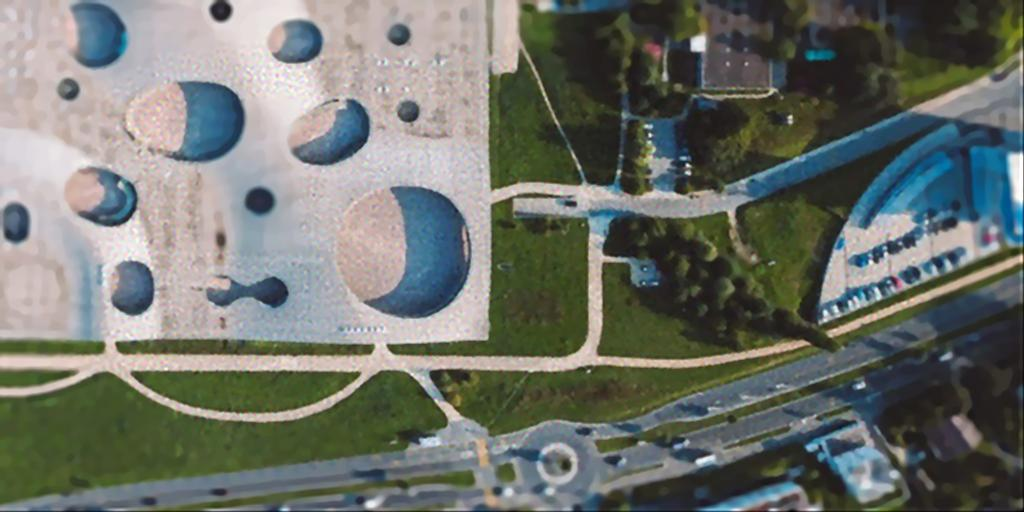
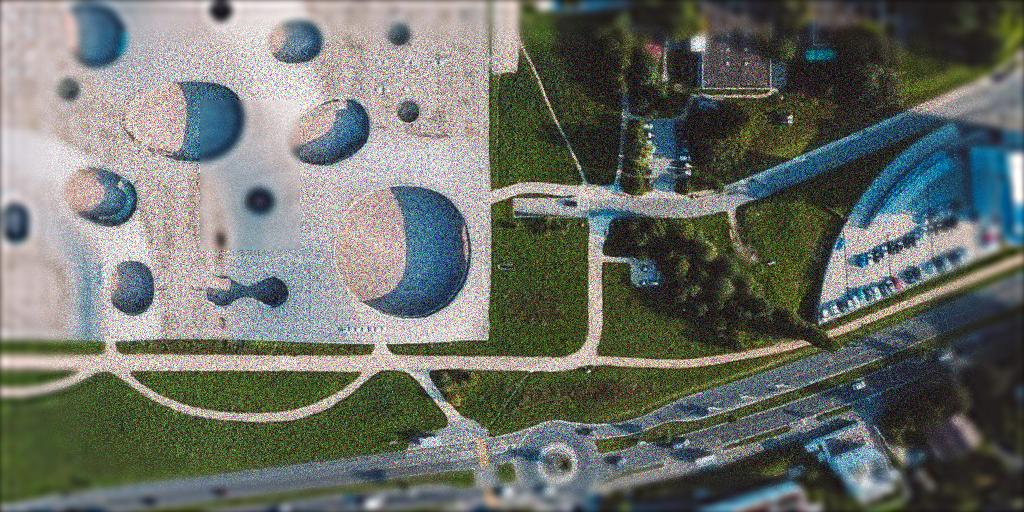

In [22]:
compare(isotv_solution.clip(0, 1), pinv_solution.clip(0, 1), circle_fraction=0.1)

### Plug and Play

In [23]:
from pyxu.abc.operator import ProxFunc
from pyxu.info.deps import NDArrayInfo

class MedianFilter(ProxFunc):
    def __init__(self, dim_shape, filter_size=3):
        super().__init__(dim_shape=dim_shape, codim_shape=(1,))
        self._filter_size = filter_size
        
    def apply(self, arr):
        return NotImplemented
        
    def prox(self, arr, tau=None):
        if NDArrayInfo.from_obj(arr) == NDArrayInfo.NUMPY:
            import scipy.ndimage as cpu_ndimage
            median_filter = cpu_ndimage.median_filter
        if NDArrayInfo.from_obj(arr) == NDArrayInfo.CUPY:
            import cupyx.scipy.ndimage as gpu_ndimage
            median_filter = gpu_ndimage.median_filter
        return median_filter(arr, size=self._filter_size)

median_op = MedianFilter(dim_shape=dim_shape, filter_size=(3, 3, 1))

In [24]:
solver = pxsol.PGD(f=loss, g=median_op, verbosity=100)

solver.fit(x0=pinv_solution, acceleration=True, stop_crit=pxst.MaxIter(250))
pnp_recons = solver.solution()

INFO -- [2024-03-25 16:40:54.637581] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO -- [2024-03-25 16:40:56.536797] Iteration 100
	iteration: 100
	N_iter: 101.0
INFO -- [2024-03-25 16:40:58.409116] Iteration 200
	iteration: 200
	N_iter: 201.0
INFO -- [2024-03-25 16:40:59.325264] Iteration 250
	iteration: 250
	N_iter: 251.0
INFO -- [2024-03-25 16:40:59.326190] Stopping Criterion satisfied -> END



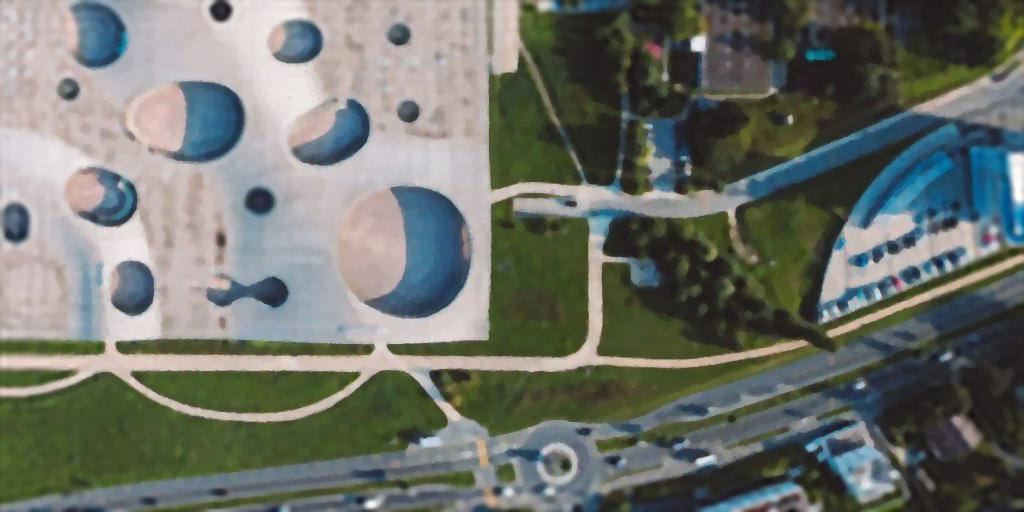
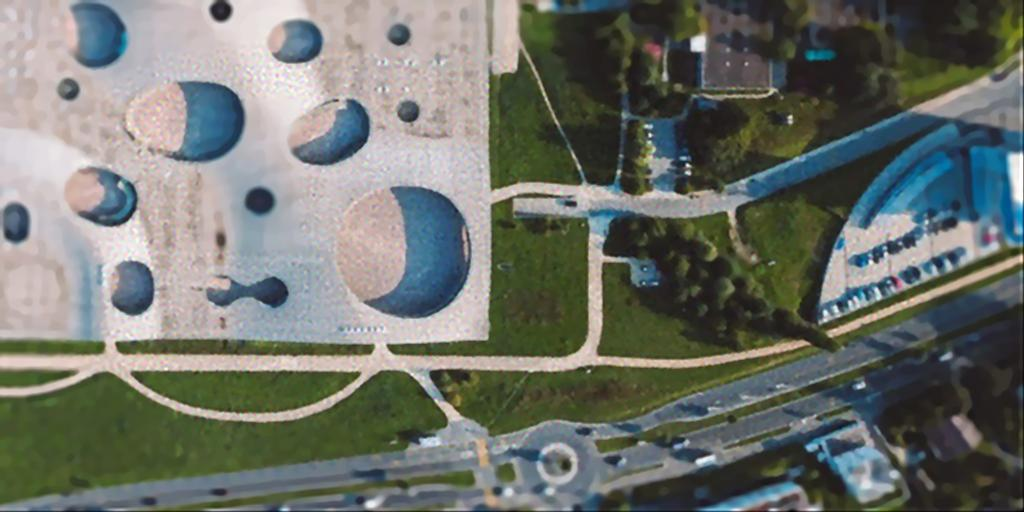

In [25]:
compare(pnp_recons.clip(0, 1), isotv_solution.clip(0, 1), circle_fraction=0.1)

### Interoperability with PyTorch

In [30]:
import torch
from nn_utils import DnCNN

model = DnCNN(in_nc=3, out_nc=3)
model.load_state_dict(torch.load("../data/nn/dncnn_trained_2.pth"))
model.eval()
device = torch.device('cuda' if (torch.cuda.is_available() & GPU) else 'cpu')
model.to(device);

In [31]:
from pyxu.operator.interop import from_torch

def denoiser_prox(arr, tau):
    with torch.no_grad():
        torch_input = arr.reshape(1, *dim_shape).permute(0, 3, 1, 2)
        im_denoised = model(torch_input)
        torch_output = im_denoised.squeeze().permute(1, 2, 0)
    return torch_output

nn_denoiser = from_torch(
    apply=None,
    prox=denoiser_prox,
    dim_shape=dim_shape,
    codim_shape=1,
    cls=ProxFunc,
    dtype="float32",
    enable_warnings=True,
    name='nn_denoiser',
)

In [34]:
solver = pxsol.PGD(f=loss, g=nn_denoiser)
solver.fit(x0=pinv_solution, acceleration=True, stop_crit=pxst.MaxIter(1))
pytorch_recons = solver.solution()


INFO -- [2024-03-25 16:41:27.371801] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO -- [2024-03-25 16:41:27.423466] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO -- [2024-03-25 16:41:27.424487] Stopping Criterion satisfied -> END



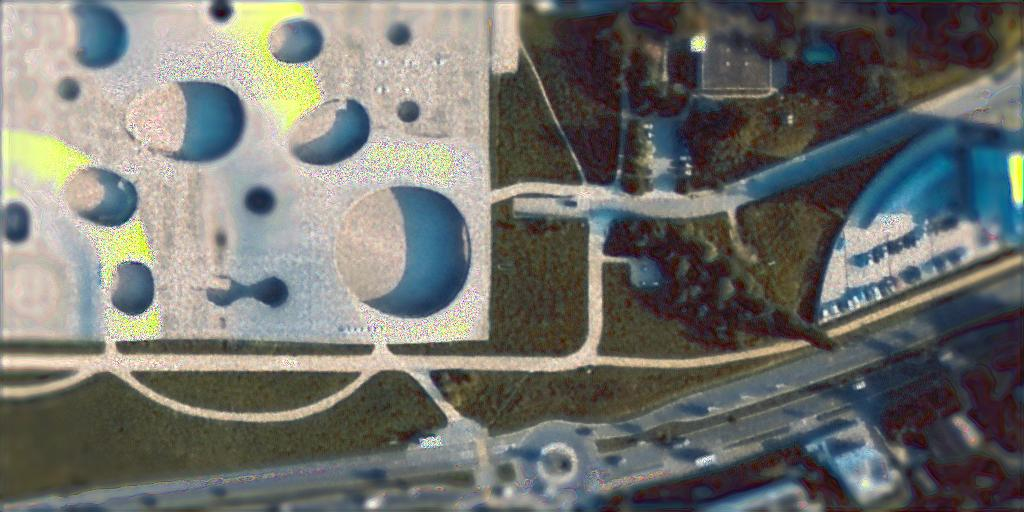
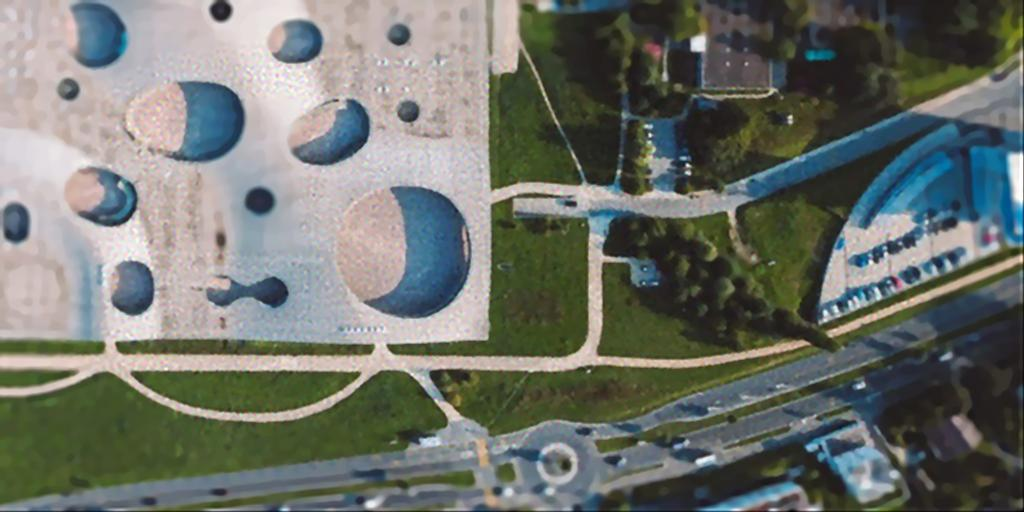

In [35]:
compare(pytorch_recons.clip(0, 1), isotv_solution.clip(0, 1), circle_fraction=0.1)